<p align="center">
<img src="Images/sorbonne_logo.png" alt="Logo" width="300"/>
</p>

# **PANEL DATA ECONOMETRICS - Code File Part 2**

* **Author**: Elia Landini
* **Student ID**: 12310239
* **Course**: EESM2-Financial Economics 
* **Class**: Panel Data Econometrics
* **Supervisor**: Jean-Bernard Chatelain 
* **Reference Paper**: Lofaro, A., & Di Bucchianico, S. (2025). Impact of monetary policy on functional income distribution: A panel vector autoregressive analysis. Economic Modelling, 107227
* **Reference Repository**: https://github.com/EliaLand/PVAR_MonetaryPolicy_FunctionalIncome

### **0) REQUIREMENTS SET-UP**

In [2]:
# Requirements.txt file installation
# !pip install -r requirements.txt

In [49]:
# Libraries import
import warnings
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import pearsonr
from scipy.stats import jarque_bera
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from statsmodels.sandbox.regression.gmm import IV2SLS
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
from linearmodels.panel import compare
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chi2
import plotly.express as px
from IPython.core.display import HTML
from IPython.display import Image

In [4]:
# Statistical Significance labelling 
def significance_stars(p):
    if p < 0.001:
        return "***"  
    elif p < 0.01:
        return "**"    
    elif p < 0.05:
        return "*"   
    else:
        return ""

In [5]:
# We supress potential warnings with this command
warnings.filterwarnings("ignore")

In [11]:
# Data loading from CodeFile Part 1 for raw data and transformed variables
final_trans_df = pd.read_csv("Data/final_trans_df.csv")
final_trans_df["year"] = pd.to_datetime(final_trans_df["year"])
# (!!!) We need to ensure a 2-level multi-index (or sm estimators won't work, in our case i="country" and t="year")
final_trans_df = final_trans_df.set_index(["country", "year"])
final_trans_df

i      P          W         WR           GDP  \
country   year                                                               
Australia 1970-01-01   7.108333    9.1   6.413648  76.120158  2.835193e+05   
          1971-01-01   7.008333    9.6   6.909308  77.071751  2.946057e+05   
          1972-01-01   5.083333   10.2   7.284607  75.808223  3.023225e+05   
          1973-01-01   6.983333   11.1   8.096658  74.465333  3.147389e+05   
          1974-01-01  13.158333   12.9   9.688749  75.817692  3.189447e+05   
...                         ...    ...        ...        ...           ...   
USA       2015-01-01   0.226667  100.0  65.600000  62.655205  1.820602e+07   
          2016-01-01   0.644167  101.3  66.400000  62.819300  1.850960e+07   
          2017-01-01   1.152500  103.4  68.600000  63.695450  1.892457e+07   
          2018-01-01   2.188333  105.9  70.900000  64.279238  1.948198e+07   
          2019-01-01   2.207500  107.9  73.100000  65.093500  1.992897e+07   

                        LS       PCOM        UN   SHORTUN  LONGUN  ...  \
country   year                                                     ...   
Australia 1970-01-01  59.7   2.113115  1.653364       NaN     NaN  ...   
          1971-01-01  60.4   2.709369  1.907799       NaN     NaN  ...   
          1972-01-01  60.3   2.925285  2.610752       NaN     NaN  ...   
          1973-01-01  60.8   4.174010  2.309362       NaN     NaN  ...   
          1974-01-01  66.9  13.802962  2.670259       NaN     NaN  ...   
...                    ...        ...       ...       ...     ...  ...   
USA       2015-01-01  56.8  66.099106  5.279920  5968.333  2328.0  ...   
          2016-01-01  56.8  56.023884  4.869110  5746.000  2005.0  ...   
          2017-01-01  56.9  69.357989  4.355201  5294.250  1688.0  ...   
          2018-01-01  56.8  89.358138  3.895676  4964.917  1349.0  ...   
          2019-01-01  56.9  78.251714  3.669213  4733.583  1267.0  ...   

                       WR_TWFE      GDP_TWFE   LS_TWFE     PCOM_TWFE  \
country   year                                                         
Australia 1970-01-01  6.652899  6.417193e+05 -1.599571  1.421085e-14   
          1971-01-01  6.815177  6.194218e+05 -1.535286  2.131628e-14   
          1972-01-01  5.360967  5.765079e+05 -1.728143  0.000000e+00   
          1973-01-01  0.878244  5.265239e+05 -0.949571  0.000000e+00   
          1974-01-01  2.643711  5.213183e+05  3.743286  1.421085e-14   
...                        ...           ...       ...           ...   
USA       2015-01-01  9.355536  5.625355e+06  0.469433  0.000000e+00   
          2016-01-01  8.342223  5.882897e+06  0.702767  1.776357e-15   
          2017-01-01  8.851479  6.232285e+06  1.196100 -1.065814e-14   
          2018-01-01  8.792271  6.728788e+06  0.876100 -1.421085e-14   
          2019-01-01  9.679027  7.128463e+06  0.522767 -1.421085e-14   

                       UN_TWFE  SHORTUN_TWFE  LONGUN_TWFE       LF_TWFE  \
country   year                                                            
Australia 1970-01-01  0.083200           NaN          NaN   3746.924114   
          1971-01-01 -0.010331           NaN          NaN   3673.600806   
          1972-01-01  0.306079           NaN          NaN   3516.775114   
          1973-01-01  0.280121           NaN          NaN   3252.168575   
          1974-01-01  0.703663           NaN          NaN   2769.733122   
...                        ...           ...          ...           ...   
USA       2015-01-01 -2.158072   -366.715087   510.316135  23419.420004   
          2016-01-01 -2.012960   -557.504449   282.317657  25183.856004   
          2017-01-01 -1.792373   -943.479016    65.509990  26116.245337   
          2018-01-01 -1.493159  -1224.491436  -171.593610  27580.072337   
          2019-01-01 -1.360396  -1436.126789  -192.683076  28785.793337   

                      REER_TWFE   SH_TWFE  
country   year                             
Australia 1970-01-01   2.873095 -2.544304  
       

### **2) PART 2A - CLASSIC BENCHMARK MULTIVARIATE PANEL DATA ESTIMATORS**

##### <span style="color: orange"> **2.20) In a single table, report and comment the results of estimations of Between, Within (one-way fixed effects, (fe)) and Mundlak (random effects (re) including all X(i.) as regressors), two-way fixed effects (add year dummies in fe regression) and First differences, including all explanatory variables except the ones with high near-multicollinearity after their transformation.** </span>

In [ ]:
# Model 1 - Estimation Results 
# Model 1 entails the state space vector for the PVAR model adopted by Lofaro, A., & Di Bucchianico, S. (2025).
# The vector is so defined: y = [PCOM, GDP, UN, P, WR, LS, i]
# Assumed Dependent Y = GDP, Assumed X = [UN, P, WR, LS, i]
# (!!!) PCOM must be taken out as it causes TWFE to crash as all the between-countries variability has been absorbed already (=0)
# (!!!) Compensation metrics (nominal and real), labour market metrics (from unemployment to market share) and monetary policy-related metrics (i, SH and REER), must not display mroe than one representative proxy in the model to avoid perfect multicollinearity issues
# (!!!) The following model specifications (Model 1, 2, 3, 4, 5) presented already in the paper are meant to prevent the accuracy loss given by the intra-metrics-group high bivariate correlation 

# //////
# Set-Up
# //////
df = final_trans_df.copy()
# Variable definition 
X_vars = ["UN", "P", "WR", "LS", "i"] 
y_var = "GDP"

# /////////////////
# Between Estimator
# /////////////////
# (!!!) Both entity (i) and time effects (t) off
# (!!!) Given the heterogeneity of our panel,w e deploy robust covariance
between_mod = PanelOLS(
    df[y_var],
    sm.add_constant(df[X_vars]),
    entity_effects=False,
    time_effects=False
).fit(cov_type="robust")

# /////////////////////
# OWFE-Within Estimator
# /////////////////////
# (!!!) Here we turn on entity effects (i)
within_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True
).fit(cov_type="robust")

# ///////////////////////////////
# Mundlak (RE + group means of X)
# ///////////////////////////////
# Iteration over regressors to get the respective group means within each country (level=0)
# (!!!) We no longer refer to "country" as a column, but as a index level (in this case the first, so 0)
for var in X_vars:
    df[f"{var}_mean"] = df.groupby(level=0)[var].transform("mean")
mundlak_X = X_vars + [f"{var}_mean" for var in X_vars]
# RE a la Mundlak
mundlak_mod = RandomEffects(
    df[y_var],
    sm.add_constant(df[mundlak_X])
).fit(cov_type="robust")

# /////////////////////
# TWFE-Within Estimator
# /////////////////////
# (!!!) Both entity (i) and time effects (t) on this time 
# (!!!) Same approach as between and within estimators, but we turn on both parameters this time
TWFE_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True,
    time_effects=True
).fit(cov_type="robust")

# ///////////////////////////
# First Differences Estimator
# ///////////////////////////
# We have to take NaN out, otherwise the run crashes
# (!!!) Faster to go directly with .diff() instead of filtering the already transformed variables from final_trans_df
# (!!!) I cannot call the df starting with a number like 1diff, like I would, cuz it's not accepted 
diff_df = df.groupby(level=0).diff().dropna()
# We now plug as usual 1diff in the PanelOLS
diff_mod = PanelOLS(
    diff_df[y_var],
    diff_df[X_vars]
).fit(cov_type="robust")

# ////////////
# Tabular Form
# ////////////
# (!!!) Nice comparison command (FANTASTIC!), it basically requires no adjustments
results = {
    "Between": between_mod,
    "OWFE-Within": within_mod,
    "RE-Mundlak": mundlak_mod,
    "TWFE-Within": TWFE_mod,
    "First Differences": diff_mod
}

comparison = compare(results)
comparison

,Between,OWFE-Within,RE-Mundlak,TWFE-Within,First Differences
Dep. Variable,GDP,GDP,GDP,GDP,GDP
Estimator,PanelOLS,PanelOLS,RandomEffects,PanelOLS,PanelOLS
No. Observations,731,731,731,731,555
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.1035,0.2890,0.2891,0.0727,0.2673
R-Squared (Within),0.1498,0.2890,0.2890,0.0705,0.1728
R-Squared (Between),0.1005,0.3205,0.2969,0.2776,0.3076
R-Squared (Overall),0.1035,0.3093,0.3076,0.2471,0.2673
F-statistic,16.748,57.793,29.286,10.378,40.128
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


In [18]:
# Model 2 - Estimation Results 
# Model 2 entails the state space vector for the PVAR model adopted by Lofaro, A., & Di Bucchianico, S. (2025).
# The vector is so defined: y = [PCOM, GDP, UN, P, W, LS, i]
# Assumed Dependent Y = GDP, Assumed X = [UN, P, W, LS, i]
# (!!!) PCOM must be taken out as it causes TWFE to crash as all the between-countries variability has been absorbed already (=0)

# //////
# Set-Up
# //////
df = final_trans_df.copy()
# Variable definition 
# (!!!) Nominal compensation (W), instead of real (WR)
X_vars = ["UN", "P", "W", "LS", "i"] 
y_var = "GDP"

# /////////////////
# Between Estimator
# /////////////////
# (!!!) Both entity (i) and time effects (t) off
# (!!!) Given the heterogeneity of our panel,w e deploy robust covariance
between_mod = PanelOLS(
    df[y_var],
    sm.add_constant(df[X_vars]),
    entity_effects=False,
    time_effects=False
).fit(cov_type="robust")

# /////////////////////
# OWFE-Within Estimator
# /////////////////////
# (!!!) Here we turn on entity effects (i)
within_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True
).fit(cov_type="robust")

# ///////////////////////////////
# Mundlak (RE + group means of X)
# ///////////////////////////////
# Iteration over regressors to get the respective group means within each country (level=0)
# (!!!) We no longer refer to "country" as a column, but as a index level (in this case the first, so 0)
for var in X_vars:
    df[f"{var}_mean"] = df.groupby(level=0)[var].transform("mean")
mundlak_X = X_vars + [f"{var}_mean" for var in X_vars]
# RE a la Mundlak
mundlak_mod = RandomEffects(
    df[y_var],
    sm.add_constant(df[mundlak_X])
).fit(cov_type="robust")

# /////////////////////
# TWFE-Within Estimator
# /////////////////////
# (!!!) Both entity (i) and time effects (t) on this time 
# (!!!) Same approach as between and within estimators, but we turn on both parameters this time
TWFE_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True,
    time_effects=True
).fit(cov_type="robust")

# ///////////////////////////
# First Differences Estimator
# ///////////////////////////
# We have to take NaN out, otherwise the run crashes
# (!!!) Faster to go directly with .diff() instead of filtering the already transformed variables from final_trans_df
# (!!!) I cannot call the df starting with a number like 1diff, like I would, cuz it's not accepted 
diff_df = df.groupby(level=0).diff().dropna()
# We now plug as usual 1diff in the PanelOLS
diff_mod = PanelOLS(
    diff_df[y_var],
    diff_df[X_vars]
).fit(cov_type="robust")

# ////////////
# Tabular Form
# ////////////
# (!!!) Nice comparison command (FANTASTIC!)
results = {
    "Between": between_mod,
    "OWFE-Within": within_mod,
    "RE-Mundlak": mundlak_mod,
    "TWFE-Within": TWFE_mod,
    "First Differences": diff_mod
}

comparison = compare(results)
comparison

,Between,OWFE-Within,RE-Mundlak,TWFE-Within,First Differences
Dep. Variable,GDP,GDP,GDP,GDP,GDP
Estimator,PanelOLS,PanelOLS,RandomEffects,PanelOLS,PanelOLS
No. Observations,731,731,731,731,555
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.1654,0.3257,0.3259,0.1510,0.2534
R-Squared (Within),0.1355,0.3257,0.3257,-0.4487,0.1698
R-Squared (Between),0.1708,0.3712,0.3343,0.1900,0.2770
R-Squared (Overall),0.1654,0.3616,0.3453,0.1103,0.2534
F-statistic,28.744,68.697,34.809,23.555,37.332
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
# Model 3 - Estimation Results 
# Model 3 entails the state space vector for the PVAR model adopted by Lofaro, A., & Di Bucchianico, S. (2025).
# The vector is so defined: y = [PCOM, GDP, SHORTUN, P, WR, LS, i]
# Assumed Dependent Y = GDP, Assumed X = [SHORTUN, P, WR, LS, i]
# (!!!) PCOM must be taken out as it causes TWFE to crash as all the between-countries variability has been absorbed already (=0)

# //////
# Set-Up
# //////
df = final_trans_df.copy()
# Variable definition 
# (!!!) Short-run Unemployemnt (SHORTUN), instead of annual unemployment rate (UN), and WR back in instead of W
X_vars = ["SHORTUN", "P", "WR", "LS", "i"] 
y_var = "GDP"

# /////////////////
# Between Estimator
# /////////////////
# (!!!) Both entity (i) and time effects (t) off
# (!!!) Given the heterogeneity of our panel,w e deploy robust covariance
between_mod = PanelOLS(
    df[y_var],
    sm.add_constant(df[X_vars]),
    entity_effects=False,
    time_effects=False
).fit(cov_type="robust")

# /////////////////////
# OWFE-Within Estimator
# /////////////////////
# (!!!) Here we turn on entity effects (i)
within_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True
).fit(cov_type="robust")

# ///////////////////////////////
# Mundlak (RE + group means of X)
# ///////////////////////////////
# Iteration over regressors to get the respective group means within each country (level=0)
# (!!!) We no longer refer to "country" as a column, but as a index level (in this case the first, so 0)
for var in X_vars:
    df[f"{var}_mean"] = df.groupby(level=0)[var].transform("mean")
mundlak_X = X_vars + [f"{var}_mean" for var in X_vars]
# RE a la Mundlak
mundlak_mod = RandomEffects(
    df[y_var],
    sm.add_constant(df[mundlak_X])
).fit(cov_type="robust")

# /////////////////////
# TWFE-Within Estimator
# /////////////////////
# (!!!) Both entity (i) and time effects (t) on this time 
# (!!!) Same approach as between and within estimators, but we turn on both parameters this time
TWFE_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True,
    time_effects=True
).fit(cov_type="robust")

# ///////////////////////////
# First Differences Estimator
# ///////////////////////////
# We have to take NaN out, otherwise the run crashes
# (!!!) Faster to go directly with .diff() instead of filtering the already transformed variables from final_trans_df
# (!!!) I cannot call the df starting with a number like 1diff, like I would, cuz it's not accepted 
diff_df = df.groupby(level=0).diff().dropna()
# We now plug as usual 1diff in the PanelOLS
diff_mod = PanelOLS(
    diff_df[y_var],
    diff_df[X_vars]
).fit(cov_type="robust")

# ////////////
# Tabular Form
# ////////////
# (!!!) Nice comparison command (FANTASTIC!)
results = {
    "Between": between_mod,
    "OWFE-Within": within_mod,
    "RE-Mundlak": mundlak_mod,
    "TWFE-Within": TWFE_mod,
    "First Differences": diff_mod
}

comparison = compare(results)
comparison

,Between,OWFE-Within,RE-Mundlak,TWFE-Within,First Differences
Dep. Variable,GDP,GDP,GDP,GDP,GDP
Estimator,PanelOLS,PanelOLS,RandomEffects,PanelOLS,PanelOLS
No. Observations,585,585,585,585,555
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.8222,0.4168,0.5705,0.2520,0.3935
R-Squared (Within),0.1165,0.4168,0.4154,-1.6040,0.5530
R-Squared (Between),0.9466,-1.8818,0.9495,-8.0634,0.3036
R-Squared (Overall),0.8222,-1.1028,0.8756,-5.5667,0.3935
F-statistic,535.50,80.751,76.257,34.760,71.376
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


In [21]:
# Model 4 - Estimation Results 
# Model 4 entails the state space vector for the PVAR model adopted by Lofaro, A., & Di Bucchianico, S. (2025).
# The vector is so defined: y = [PCOM, GDP, LONGUN, P, WR, LS, i]
# Assumed Dependent Y = GDP, Assumed X = [LONGUN, P, WR, LS, i]
# (!!!) PCOM must be taken out as it causes TWFE to crash as all the between-countries variability has been absorbed already (=0)

# //////
# Set-Up
# //////
df = final_trans_df.copy()
# Variable definition 
# (!!!) Long-run Unemployemnt (LONGUN), instead of annual unemployment rate (UN)
X_vars = ["LONGUN", "P", "WR", "LS", "i"] 
y_var = "GDP"

# /////////////////
# Between Estimator
# /////////////////
# (!!!) Both entity (i) and time effects (t) off
# (!!!) Given the heterogeneity of our panel,w e deploy robust covariance
between_mod = PanelOLS(
    df[y_var],
    sm.add_constant(df[X_vars]),
    entity_effects=False,
    time_effects=False
).fit(cov_type="robust")

# /////////////////////
# OWFE-Within Estimator
# /////////////////////
# (!!!) Here we turn on entity effects (i)
within_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True
).fit(cov_type="robust")

# ///////////////////////////////
# Mundlak (RE + group means of X)
# ///////////////////////////////
# Iteration over regressors to get the respective group means within each country (level=0)
# (!!!) We no longer refer to "country" as a column, but as a index level (in this case the first, so 0)
for var in X_vars:
    df[f"{var}_mean"] = df.groupby(level=0)[var].transform("mean")
mundlak_X = X_vars + [f"{var}_mean" for var in X_vars]
# RE a la Mundlak
mundlak_mod = RandomEffects(
    df[y_var],
    sm.add_constant(df[mundlak_X])
).fit(cov_type="robust")

# /////////////////////
# TWFE-Within Estimator
# /////////////////////
# (!!!) Both entity (i) and time effects (t) on this time 
# (!!!) Same approach as between and within estimators, but we turn on both parameters this time
TWFE_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True,
    time_effects=True
).fit(cov_type="robust")

# ///////////////////////////
# First Differences Estimator
# ///////////////////////////
# We have to take NaN out, otherwise the run crashes
# (!!!) Faster to go directly with .diff() instead of filtering the already transformed variables from final_trans_df
# (!!!) I cannot call the df starting with a number like 1diff, like I would, cuz it's not accepted 
diff_df = df.groupby(level=0).diff().dropna()
# We now plug as usual 1diff in the PanelOLS
diff_mod = PanelOLS(
    diff_df[y_var],
    diff_df[X_vars]
).fit(cov_type="robust")

# ////////////
# Tabular Form
# ////////////
# (!!!) Nice comparison command (FANTASTIC!)
results = {
    "Between": between_mod,
    "OWFE-Within": within_mod,
    "RE-Mundlak": mundlak_mod,
    "TWFE-Within": TWFE_mod,
    "First Differences": diff_mod
}

comparison = compare(results)
comparison

,Between,OWFE-Within,RE-Mundlak,TWFE-Within,First Differences
Dep. Variable,GDP,GDP,GDP,GDP,GDP
Estimator,PanelOLS,PanelOLS,RandomEffects,PanelOLS,PanelOLS
No. Observations,585,585,585,585,555
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.3218,0.4761,0.4727,0.3055,0.3017
R-Squared (Within),0.0681,0.4761,0.4761,-0.5952,0.2922
R-Squared (Between),0.3554,-3.2211,0.4187,-10.572,0.3005
R-Squared (Overall),0.3218,-2.0440,0.4601,-7.3045,0.3017
F-statistic,54.936,102.70,51.455,45.396,47.526
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


In [23]:
# Model 5 - Estimation Results 
# Model 5 entails the state space vector for the PVAR model adopted by Lofaro, A., & Di Bucchianico, S. (2025).
# The vector is so defined: y = [PCOM, GDP, LF, P, WR, LS, i]
# Assumed Dependent Y = GDP, Assumed X = [LF, P, WR, LS, i]
# (!!!) PCOM must be taken out as it causes TWFE to crash as all the between-countries variability has been absorbed already (=0)

# //////
# Set-Up
# //////
df = final_trans_df.copy()
# Variable definition 
# (!!!) Labour Force Share (LS), instead of annual unemployment rate (UN)
X_vars = ["LF", "P", "WR", "LS", "i"] 
y_var = "GDP"

# /////////////////
# Between Estimator
# /////////////////
# (!!!) Both entity (i) and time effects (t) off
# (!!!) Given the heterogeneity of our panel,w e deploy robust covariance
between_mod = PanelOLS(
    df[y_var],
    sm.add_constant(df[X_vars]),
    entity_effects=False,
    time_effects=False
).fit(cov_type="robust")

# /////////////////////
# OWFE-Within Estimator
# /////////////////////
# (!!!) Here we turn on entity effects (i)
within_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True
).fit(cov_type="robust")

# ///////////////////////////////
# Mundlak (RE + group means of X)
# ///////////////////////////////
# Iteration over regressors to get the respective group means within each country (level=0)
# (!!!) We no longer refer to "country" as a column, but as a index level (in this case the first, so 0)
for var in X_vars:
    df[f"{var}_mean"] = df.groupby(level=0)[var].transform("mean")
mundlak_X = X_vars + [f"{var}_mean" for var in X_vars]
# RE a la Mundlak
mundlak_mod = RandomEffects(
    df[y_var],
    sm.add_constant(df[mundlak_X])
).fit(cov_type="robust")

# /////////////////////
# TWFE-Within Estimator
# /////////////////////
# (!!!) Both entity (i) and time effects (t) on this time 
# (!!!) Same approach as between and within estimators, but we turn on both parameters this time
TWFE_mod = PanelOLS(
    df[y_var],
    df[X_vars],
    entity_effects=True,
    time_effects=True
).fit(cov_type="robust")

# ///////////////////////////
# First Differences Estimator
# ///////////////////////////
# We have to take NaN out, otherwise the run crashes
# (!!!) Faster to go directly with .diff() instead of filtering the already transformed variables from final_trans_df
# (!!!) I cannot call the df starting with a number like 1diff, like I would, cuz it's not accepted 
diff_df = df.groupby(level=0).diff().dropna()
# We now plug as usual 1diff in the PanelOLS
diff_mod = PanelOLS(
    diff_df[y_var],
    diff_df[X_vars]
).fit(cov_type="robust")

# ////////////
# Tabular Form
# ////////////
# (!!!) Nice comparison command (FANTASTIC!)
results = {
    "Between": between_mod,
    "OWFE-Within": within_mod,
    "RE-Mundlak": mundlak_mod,
    "TWFE-Within": TWFE_mod,
    "First Differences": diff_mod
}

comparison = compare(results)
comparison

,Between,OWFE-Within,RE-Mundlak,TWFE-Within,First Differences
Dep. Variable,GDP,GDP,GDP,GDP,GDP
Estimator,PanelOLS,PanelOLS,RandomEffects,PanelOLS,PanelOLS
No. Observations,731,731,731,731,555
Cov. Est.,Robust,Robust,Robust,Robust,Robust
R-squared,0.9521,0.9274,0.9353,0.9095,0.5109
R-Squared (Within),0.7718,0.9274,0.9274,0.9113,-0.1336
R-Squared (Between),0.9842,0.0219,0.9935,-0.1568,0.8463
R-Squared (Overall),0.9521,0.1464,0.9830,-0.0087,0.5109
F-statistic,2884.6,1816.1,1041.0,1330.2,114.90
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000


##### <span style="color: orange"> **2.21) If, for the first differences dependent variable, it remains a simple auto-correlation above 0.1, a dynamic panel estimator can be tried. The estimators of the generalized method of moments (GMM) for panel data are only valid for short time panel T<10 and they face the issue of too many weak instruments. We suggest using its precursor, the Anderson-Hsiao (1981) estimator which allows to check the first stage of instrumental variables and to test for weak lagged instruments. Estimate an auto-regressive distributed lag (ARDL) model for dynamic panel data including the first lag of the dependent variable (for example: GDP per head growth) and the first lag of the key explanatory variable (for example: foreign aid/GDP), adding the first lag of other control variables is optional: Δ GDPGi,t = βy Δ GDPGi,t-1 + β1 Δ (aid/GDP)i,t + β2 Δ (aid/GDP)i,t-1 + Δ Controls i,t + Δ αi + Δ αt + Δ εi** </span>

In [ ]:
# Autocorrelation in first-difference sanity check 
# (!!!) We rerun the first differences estimator for Model 1 as we just did (only to get the residuals)
# (!!!) It could be better...we still have strong first-order serial correlation in the first-differenced residuals
df = final_trans_df.copy()
diff_df = df.groupby(level=0).diff().dropna()
X_vars = ["UN", "P", "WR", "LS", "i"] 
y_var = "GDP"
diff_mod = PanelOLS(
    diff_df[y_var],
    diff_df[X_vars]
).fit(cov_type="robust")

# We get teh residuals from teh estimation
resid = diff_mod.resids
# Lag residuals within entity (country)
resid_lag = resid.groupby(level=0).shift(1)
# When we drop NaN we also shift the index, bringing OLS to crash 
tmp = (
    resid.to_frame("resid")
    .join(resid_lag.to_frame("resid_lag"), how="inner")
    .dropna()
)

# /////////////////////////////
# AR(1) regression of residuals
# /////////////////////////////
ar1 = sm.OLS(
    tmp["resid"], 
    sm.add_constant(tmp["resid_lag"])).fit()

print(ar1.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     650.4
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.22e-94
Time:                        06:03:24   Log-Likelihood:                -6770.2
No. Observations:                 540   AIC:                         1.354e+04
Df Residuals:                     538   BIC:                         1.355e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1444.6732   2907.389      0.497      0.6

In [36]:
# Dynamic Model Try 1 on Model 1 - Anderson-Hsiao ARDL Model
# (!!!) We introduce the lag of GDP_1diff as IV: ΔGDP_it​=αΔGDP_i,t−1 ​+ βΔX_i,t−1 ​+ Δε_it​

# Model 1 (but here we take directly the earlier computed 1diff)
df = final_trans_df.copy()
x_vars = ["UN_1diff", "P_1diff", "WR_1diff", "LS_1diff", "i_1diff"]  
y_var = "GDP_1diff"

# ////////////////////////
# Lagged First Differences
# ////////////////////////
# Lag 1 - Model Switch to t-1 differences
df["GDP_1diff_lag1"] = df.groupby(level=0)["GDP_1diff"].shift(1)
for var in ["UN", "P", "WR", "LS", "i"]:
    df[f"{var}_1diff_lag1"] = df.groupby(level=0)[f"{var}_1diff"].shift(1)

# /////////////////////////
# IV (levels, lagged twice)
# /////////////////////////
# IV introduction, the new lagged variables are introduced as IVs
# (!!!) same thing
df["GDP_lag2"] = df.groupby(level=0)["GDP"].shift(2)
for var in ["UN", "P", "WR", "LS", "i"]:
    df[f"{var}_lag2"] = df.groupby(level=0)[var].shift(2)

diff_ah_df = df.dropna().copy()
diff_ah_df

i      P          W         WR           GDP  \
country   year                                                               
Australia 1979-01-01   9.773333   22.2  13.731084  64.057388  3.666439e+05   
          1980-01-01  12.027500   24.5  15.360311  65.243434  3.788880e+05   
          1981-01-01  15.038333   26.8  17.229549  66.610960  3.914854e+05   
          1982-01-01  16.834167   29.8  18.147008  62.596215  3.827767e+05   
          1983-01-01  12.199167   32.8  18.663543  59.324627  4.003528e+05   
...                         ...    ...        ...        ...           ...   
USA       2015-01-01   0.226667  100.0  65.600000  62.655205  1.820602e+07   
          2016-01-01   0.644167  101.3  66.400000  62.819300  1.850960e+07   
          2017-01-01   1.152500  103.4  68.600000  63.695450  1.892457e+07   
          2018-01-01   2.188333  105.9  70.900000  64.279238  1.948198e+07   
          2019-01-01   2.207500  107.9  73.100000  65.093500  1.992897e+07   

                        LS       PCOM        UN    SHORTUN    LONGUN  ...  \
country   year                                                        ...   
Australia 1979-01-01  61.8  39.038400  6.272239   267.2561   141.155  ...   
          1980-01-01  63.5  46.784376  6.108837   268.2876   140.323  ...   
          1981-01-01  63.2  46.862101  5.790206   259.5776   134.307  ...   
          1982-01-01  65.2  44.011515  7.164390   325.1490   169.776  ...   
          1983-01-01  61.0  39.344682  9.968244   381.3644   315.674  ...   
...                    ...        ...       ...        ...       ...  ...   
USA       2015-01-01  56.8  66.099106  5.279920  5968.3330  2328.000  ...   
          2016-01-01  56.8  56.023884  4.869110  5746.0000  2005.000  ...   
          2017-01-01  56.9  69.357989  4.355201  5294.2500  1688.000  ...   
          2018-01-01  56.8  89.358138  3.895676  4964.9170  1349.000  ...   
          2019-01-01  56.9  78.251714  3.669213  4733.5830  1267.000  ...   

                      P_1diff_lag1  WR_1diff_lag1  LS_1diff_lag1  \
country   year                                                     
Australia 1979-01-01           1.5      -1.388926           -3.4   
          1980-01-01           1.8      -0.792615           -0.9   
          1981-01-01           2.3       1.186046            1.7   
          1982-01-01           2.3       1.367526           -0.3   
          1983-01-01           3.0      -4.014745            2.0   
...                            ...            ...            ...   
USA       2015-01-01           1.6       0.519861            0.2   
          2016-01-01           0.1       1.035147            0.6   
          2017-01-01           1.3       0.164095            0.0   
          2018-01-01           2.1       0.876150            0.1   
          2019-01-01           2.5       0.583788           -0.1   

                      i_1diff_lag1      GDP_lag2   UN_lag2  P_lag2    WR_lag2  \
country   year                                                                  
Australia 1979-01-01     -0.369167  3.419913e+05  5.631336    18.9  66.238930   
          1980-01-01     -0.070000  3.558420e+05  6.360409    20.4  64.850003   
          1981-01-01      2.254167  3.666439e+05  6.272239    22.2  64.057388   
          1982-01-01      3.010833  3.788880e+05  6.108837    24.5  65.243434   
          1983-01-01      1.795833  3.914854e+05  5.790206    26.8  66.610960   
...                            ...           ...       ...     ...        ...   
USA       2015-01-01     -0.042500  1.732982e+07  7.374921    98.3  61.100196   
          2016-01-01      0.102500  1.772628e+07  6.167462    99.9  61.620058   
          2017-01-01      0.417500  1.820602e+07  5.279920   100.0  62.655205   
          2018-01-01      0.508333  1.850960e+07  4.869110   101.3  62.819300   
          2019-01-01      1.035833  1.892457e+07  4.355201   103.4  63.695450   

                      LS_lag2     i_lag2  
country   year                 

In [ ]:
# IV Relevance Check _ GDP_lag2 and P_lag2
# We check whether the introduction of lagged GDP (dependent) and P (key regressor) is actually relevant to reduce the risk of endogeneity 
# (!!!) No need to turn in IV all the regressors, we can just assume one 
# (!!!) Both instruments are highly relevant, jointly, they are extremely strong, we have no weak-instrument issue
Z = sm.add_constant(diff_ah_df[
    ["GDP_lag2", "P_lag2"]
])
fs_y = sm.OLS(diff_ah_df["GDP_1diff_lag1"], Z).fit()
print(fs_y.summary())

                            OLS Regression Results                            
Dep. Variable:         GDP_1diff_lag1   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     355.7
Date:                Sun, 28 Dec 2025   Prob (F-statistic):          1.01e-100
Time:                        07:27:01   Log-Likelihood:                -7131.3
No. Observations:                 568   AIC:                         1.427e+04
Df Residuals:                     565   BIC:                         1.428e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.156e+04   9616.278      4.322      0.0

In [42]:
# Anderson-Hsiao ARDL Model

# //////
# Set-Up
# //////
# Dependent (1diff)
Y = diff_ah_df["GDP_1diff"]
# Regressors
# (!!!) Lagged1(1diff of key reg and dependent) + non-transformed 1diff controls
X = sm.add_constant(diff_ah_df[
    ["GDP_1diff_lag1",
    "P_1diff_lag1",
    "P_1diff",
    "UN_1diff",
    "WR_1diff",
    "LS_1diff",
    "i_1diff"]
])
# Instruments 
# (!!!) Lagged2(1diff of key reg and dependent), no changes in controls
# (!!!) Both lags (P_1diff_lag1) and levels (GDP_lag2 and P_lag2)
# (!!!) We basically check the endogenous-supossed x var (GDP_1diff_lag1, autocorrelation) with the 2 instruments/levels (GDP_lag2 and P_lag2), see relevance check
Z = sm.add_constant(diff_ah_df[
    ["UN_1diff", "WR_1diff", "LS_1diff", "i_1diff",
     "P_1diff", "P_1diff_lag1", "GDP_lag2", "P_lag2"]
])

# //////////
# Estimation
# //////////
ah_ardl = IV2SLS(Y, X, Z).fit()
print(ah_ardl.summary())

                          IV2SLS Regression Results                           
Dep. Variable:              GDP_1diff   R-squared:                       0.495
Model:                         IV2SLS   Adj. R-squared:                  0.488
Method:                     Two Stage   F-statistic:                     102.6
                        Least Squares   Prob (F-statistic):           4.31e-96
Date:                Sun, 28 Dec 2025                                         
Time:                        07:27:10                                         
No. Observations:                 568                                         
Df Residuals:                     560                                         
Df Model:                           7                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7634.0584   8340.533     -0.

##### <span style="color: orange"> **2.21.1) For all these variables: ΔGDPGi,t  Δ GDPGi,t-1 Δ (aid/GDP)i,t  Δ(aid/GDP)i,t-1  GDPGi,t-2  (aid/GDP)i,t-2 report univariate statistics (mean median standard error,  skewness, kurtosis, min max) and comment.** </span>

In [44]:
# Univariate Descriptive Statistics
# General outlook on descriptive statistic of within and between transformed preferred (target) variables
# Count, mean, std, min, max, intra-quartiles (25th, 50th, 75th) + Skewness, Kurtosis

target_variables = [
    "GDP_1diff", "GDP_1diff_lag1", "GDP_lag2",
    "P_1diff", "P_1diff_lag1", "P_lag2",
    "UN_1diff", "WR_1diff", "LS_1diff", "i_1diff"
]       
df = diff_ah_df[target_variables] 

desc_df = df.describe().T                         
desc_df["skewness"] = df.skew()                    
desc_df["kurtosis"] = df.kurtosis()                
diff_ah_desc_df = desc_df.copy()

diff_ah_desc_df

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
GDP_1diff,568.0,4.886941e+04,1.044032e+05,-425777.110000,6514.078250,2.013343e+04,4.713568e+04,6.046276e+05,2.644365,10.125456
GDP_1diff_lag1,568.0,4.846772e+04,1.032222e+05,-425777.110000,6362.659750,2.013343e+04,4.752061e+04,6.046276e+05,2.649645,10.387990
GDP_lag2,568.0,2.216018e+06,3.281422e+06,107716.741000,361968.471000,1.077662e+06,2.442926e+06,1.892457e+07,3.039240,9.865826
P_1diff,568.0,1.769542e+00,1.095222e+00,-1.400000,1.100000,1.700000e+00,2.400000e+00,6.300000e+00,0.391344,0.947486
P_1diff_lag1,568.0,1.792782e+00,1.105255e+00,-1.400000,1.100000,1.700000e+00,2.400000e+00,6.300000e+00,0.373742,0.846819
P_lag2,568.0,7.245951e+01,2.292754e+01,13.200000,57.250000,7.640000e+01,9.210000e+01,1.055000e+02,-0.644293,-0.472905
UN_1diff,568.0,-5.456421e-02,1.026451e+00,-3.365892,-0.590636,-1.939866e-01,3.600029e-01,6.602189e+00,1.410023,6.239244
WR_1diff,568.0,3.089173e-01,1.184970e+00,-4.847550,-0.385323,4.013103e-01,9.995565e-01,4.688748e+00,-0.454094,1.804483
LS_1diff,568.0,-1.580986e-01,1.012673e+00,-5.900000,-0.700000,-2.000000e-01,3.250000e-01,4.700000e+00,-0.064323,3.411168
i_1diff,568.0,-2.403590e-01,1.473194e+00,-5.478333,-0.902848,-1.000000e-01,4.532774e-01,5.246667e+00,-0.347340,1.659669


##### <span style="color: orange"> **2.21.2) Report the bivariate simple correlation coefficients matrix. The correlation between Δ GDPGi,t-1 Δ (aid/GDP)i,t  Δ (aid/GDP)i,t-1  and the instruments in levels: GDPGi,t-2  (aid/GDP)i,t-2 is a preliminary check for the strength of these instruments.** </span>

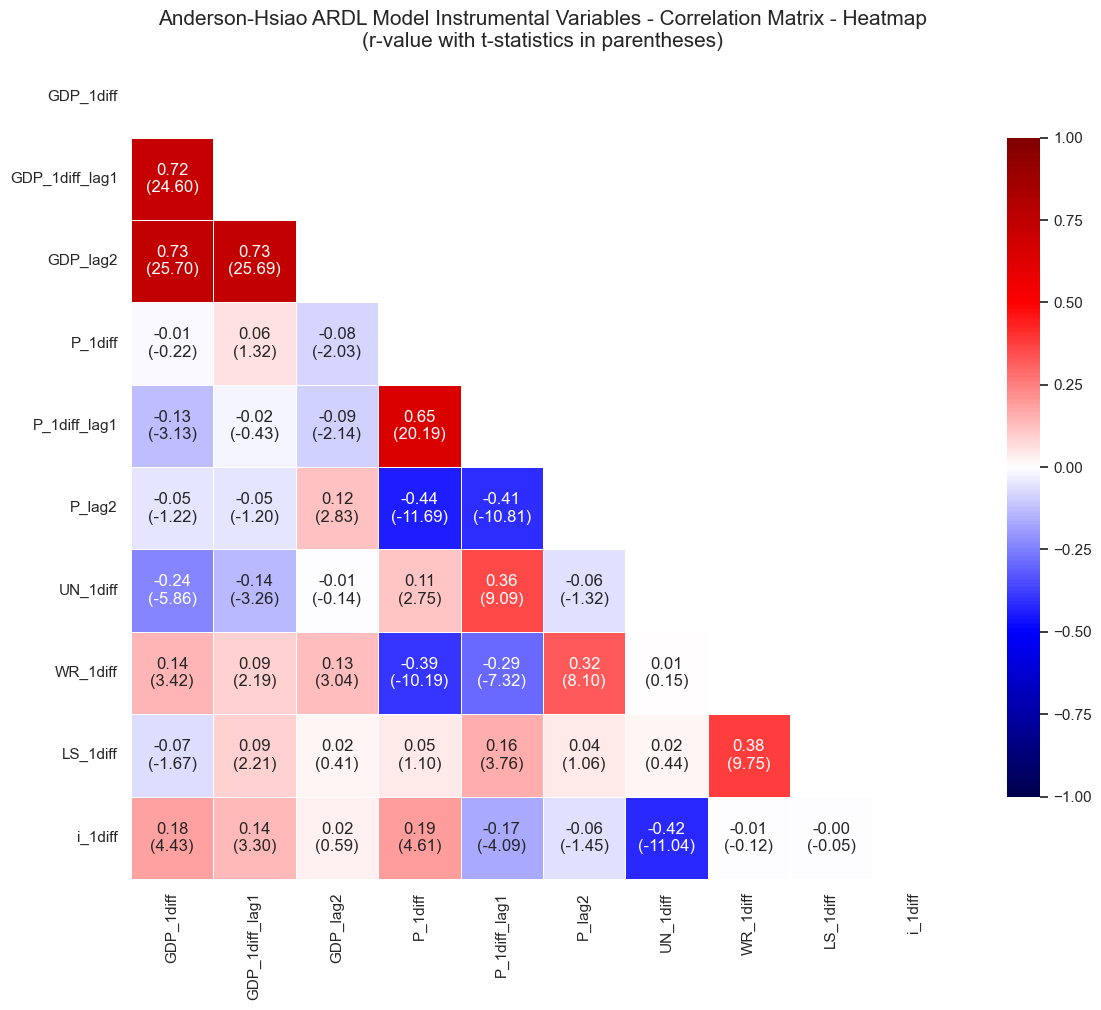

In [45]:
# Anderson-Hsiao ARDL Model Instrumental Variables - Correlation Heatmap
# Dependent, explanatory, controls, lagged, levels
df = diff_ah_df[[    
    "GDP_1diff", "GDP_1diff_lag1", "GDP_lag2",
    "P_1diff", "P_1diff_lag1", "P_lag2",
    "UN_1diff", "WR_1diff", "LS_1diff", "i_1diff"
    ]].dropna().copy()

# ////////
# Plotting
# ////////
# Correlation matrix
corr_matrix = df.corr()
# Sample size
n = df.shape[0]

# t-statistics derived from correlation values
with np.errstate(divide="ignore", invalid="ignore"):
    t_stat_matrix = corr_matrix * np.sqrt((n - 2) / (1 - corr_matrix**2))
    t_stat_matrix = t_stat_matrix.round(2)

# For each cell, we want to have both the correlation index, as well as the just computed t-statistics
annot_matrix = corr_matrix.copy().astype(str)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
# We only want to keep the lower triangle and diagonal of the full correlation matrix
        if i >= j: 
            r = corr_matrix.iloc[i, j]
            t = t_stat_matrix.iloc[i, j]
            annot_matrix.iloc[i, j] = f"{r:.2f}\n({t:.2f})"
        else:
            annot_matrix.iloc[i, j] = ""

# We manually hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heat-map plot
# General Layout (figure's size and style)
plt.figure(figsize=(12, 10))
sns.set(style="white")

sns.heatmap(corr_matrix,
            mask=mask,
            annot=annot_matrix,
            fmt="",               
            cmap="seismic",          
            vmin=-1, vmax=1,       
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})


plt.title("Anderson-Hsiao ARDL Model Instrumental Variables - Correlation Matrix - Heatmap\n(r-value with t-statistics in parentheses)", 
          fontsize=15)
plt.tight_layout()
plt.show()

##### <span style="color: orange"> **2.21.3) Do a panel data unit root test of your choice on the variables ΔGDPGi,t and  Δ(aid/GDP)i,t and comment.** </span>

In [ ]:
# Unit-Root Testing (Fisher-ADF) 
# (!!!) Had to compyted Fisher-ADF manually cuz the package in linearmodels was not working
# (!!!) Test result: the null hypothesis of unit root in all panels is strongly rejected for both GDP_1diff and P_1diff, let's go!

# ///////////////////////////////////////////
# GDP_1diff Panel unit root test (Fisher-ADF) 
# ///////////////////////////////////////////
pvals_gdp = []
for _, s in diff_ah_df["GDP_1diff"].groupby(level=0):
    s = s.dropna()
    if len(s) > 3:
        pvals_gdp.append(adfuller(s, maxlag=1, autolag=None)[1])
stat_gdp = -2 * np.sum(np.log(pvals_gdp))
df_gdp = 2 * len(pvals_gdp)
pval_gdp = 1 - chi2.cdf(stat_gdp, df_gdp)
print(f"Fisher-ADF (panel) for GDP_1diff: stat={stat_gdp:.3f}, df={df_gdp}, p-value={pval_gdp:.6f}")

# ///////////////////////////////////////////
# GDP_1diff Panel unit root test (Fisher-ADF) 
# ///////////////////////////////////////////
# (!!!) Same thing
pvals_p = []
for _, s in diff_ah_df["P_1diff"].groupby(level=0):
    s = s.dropna()
    if len(s) > 3:
        pvals_p.append(adfuller(s, maxlag=1, autolag=None)[1])
stat_p = -2 * np.sum(np.log(pvals_p))
df_p = 2 * len(pvals_p)
pval_p = 1 - chi2.cdf(stat_p, df_p)
print(f"Fisher-ADF (panel) for P_1diff: stat={stat_p:.3f}, df={df_p}, p-value={pval_p:.6f}")

Fisher-ADF (panel) for GDP_1diff: stat=195.984, df=30, p-value=0.000000
Fisher-ADF (panel) for P_1diff: stat=123.814, df=30, p-value=0.000000


##### <span style="color: orange"> **2.21.4) Report the OLS including the lag of the first difference of GDPG and of other explanatory variables. Report the number of observations and the number of countries remaining in the estimation, which requires at least three consecutive observations for each country.** </span>

In [51]:
# OLS with lag 1diff of GDP and explanatory vars 
# (!!!) We just computed earlier, easy transpose
df = diff_ah_df.dropna().copy()
Y = df["GDP_1diff"]
X = sm.add_constant(df[
    ["GDP_1diff_lag1",
     "P_1diff_lag1",
     "UN_1diff_lag1",
     "WR_1diff_lag1",
     "LS_1diff_lag1",
     "i_1diff_lag1"]
])
# (!!!) We use Heteroskedasticity-Consistent covarainace (a small-sample-adjusted version of White’s robust covariance matrix)
ols_dyn = sm.OLS(Y, X).fit(cov_type="HC1")
print(ols_dyn.summary())

                            OLS Regression Results                            
Dep. Variable:              GDP_1diff   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     40.05
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.36e-40
Time:                        08:09:39   Log-Likelihood:                -7132.5
No. Observations:                 568   AIC:                         1.428e+04
Df Residuals:                     561   BIC:                         1.431e+04
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.885e+04   1.29e+04      3.

##### <span style="color: orange"> **2.21.5) Report the IV estimator (IVREG) when you use the instruments in levels GDPGi,t-2  and (aid/GDP)i,t-2 . Comment how much each parameter changes when using OLS versus IV.** </span>

##### <span style="color: orange"> **2.21.6) Report the first stage regressions. Comment the R2 of each of the first stage regressions, if below 10%, it is a signal of weak instrument. You may comment statistics available in your software for weak instruments and for testing endogeneity of instruments.** </span>

##### <span style="color: orange"> **2.21.7) Compute and plot the impulse response functions for the next four periods for 1 unit increase of aid/GDP on GDPG: t=1: β1, t=2: βy β1 + β2, t=3: βy 2 β1 + βyβ2, t=4: βy 3 β1 + βy 2 β2** </span>

##### <span style="color: orange"> **2.21.8) Compute the long run coefficient of key explanatory variable on the dependent variable and comment: βLT  = ( β1 + β2) / (1 - βy )** </span>

### **2) PART 2B - OPTIONAL (if one of your variable is time-invariant z(i))**

[Unfortunately,  Lofaro, A., & Di Bucchianico, S. (2025) present PVAR model including 14 variables, country (i) and year (t) dependent, with only one exception for Energy Commodities Price Index, which is country-invariant, and hence only time dependent.]

##### <span style="color: orange"> **2.22) If one of your variable is time-invariant z(i), run a baseline Hausman Taylor estimation (pre-coded only in STATA) including all X(i.) as instruments. Comment the results. Else skip this question.** </span>

[n.a.]

##### <span style="color: orange"> **2.23) If one of your variable is time-invariant z(i), run a between regression on z(i) explained by X(i.) and other time invariant variable (only with N observations). If the R2 is low, this may signal X(i.) are weak instruments poorly correlated with the variable z(i) to be instrumented. Comment. Else skip this question.** </span>

[n.a.]

##### <span style="color: orange"> **2.24) If one of your variable is time-invariant z(i), as seen above, time invariant explanatory variables cannot explain the time varying within variance of the dependent variable and the Hausman Taylor internal instruments estimator is not so practical. Therefore, a practical shortcut is to include a time invariant variable multiplied by a time varying variable (interaction term): z(i) multiplied for x(it). Generate such a variable Include this product AND foreign aid into a one way fixed effects regression. Plot the estimated marginal effect (derivative) with respect to ICRG as a function of EDA/GDP (which is positive and goes as far as 20%).** </span>

[n.a.]